In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from keras import datasets

2024-10-04 14:46:43.092107: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()


def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    images = images.transpose(0, 2, 3, 1)
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()


def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, 1)
    return imgs

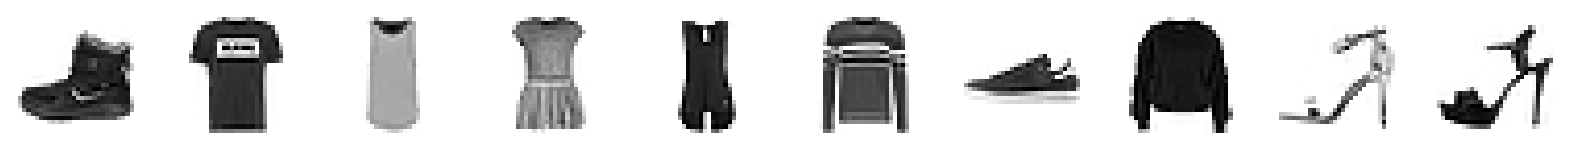

In [4]:
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()
x_train = preprocess(x_train)
x_test = preprocess(x_test)
display(x_train)

In [5]:
train_dataset = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
test_dataset = TensorDataset(torch.from_numpy(x_test), torch.from_numpy(y_test))

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

/tmp/ipykernel_43642/710054519.py:1: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1724788957849/work/torch/csrc/utils/tensor_numpy.cpp:206.)
  train_dataset = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))


In [6]:
IMAGE_SIZE = 32
BATCH_SIZE = 100
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 5
BETA = 500


class Sampling(nn.Module):
    def forward(self, inputs):
        z_mean, z_log_var = inputs
        batch = z_mean.shape[0]
        dim = z_mean.shape[1]
        epsilon = torch.rand(batch, dim)
        return z_mean + torch.exp(0.5 * z_log_var) * epsilon


class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),  # torch.Size([32, 128, 4, 4])
        )
        self.mean_layer = nn.Linear(128 * 4 * 4, EMBEDDING_DIM)
        self.var_layer = nn.Linear(128 * 4 * 4, EMBEDDING_DIM)
        self.sampling = Sampling()

    def forward(self, x):
        x = self.encoder(x)
        z_mean = self.mean_layer(x)
        z_log_var = self.var_layer(x)
        z = self.sampling((z_mean, z_log_var))

        return z_mean, z_log_var, z


class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Linear(EMBEDDING_DIM, 128 * 4 * 4),
            nn.Unflatten(1, (128, 4, 4)),
            nn.ConvTranspose2d(128, 128, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, 3, stride=1, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        decoded = self.decoder(x)
        return decoded


class AutoEncoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        z_mean, z_log_var, z = self.encoder(x)
        reconstruction = self.decoder(z)
        return z_mean, z_log_var, reconstruction

In [7]:
encoder = Encoder()
decoder = Decoder()
autoencoder = AutoEncoder(encoder, decoder)


optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)
# loss_fn = nn.MSELoss()
reconstruction_loss_fn = nn.BCELoss()
# kl_loss_fn = nn.KLDivLoss(reduction="batchmean")


for epoch in range(EPOCHS):
    # train loop
    for imgs, _ in train_dataloader:
        z_mean, z_log_var, reconstruction = autoencoder(imgs)

        reconstruction_loss = BETA * nn.functional.binary_cross_entropy(
            reconstruction, imgs, reduction="mean"
        )
        kl_loss = torch.mean(
            -0.5 * torch.sum(1 + z_log_var - z_mean**2 - torch.exp(z_log_var), dim=1)
        )
        total_loss = reconstruction_loss + kl_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

In [8]:
autoencoder.eval()

# Select a subset of the test set
n_to_predict = 5000
example_images = torch.Tensor(x_test[:n_to_predict])
example_labels = torch.Tensor(y_test[:n_to_predict])

In [ ]:
z_mean, z_log_var, reconstructions = autoencoder(example_images)


Example real clothing items


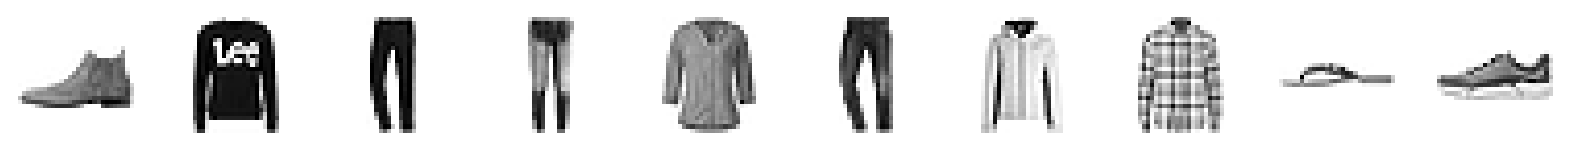

In [10]:
print("Example real clothing items")
display(example_images.numpy())


Reconstructions


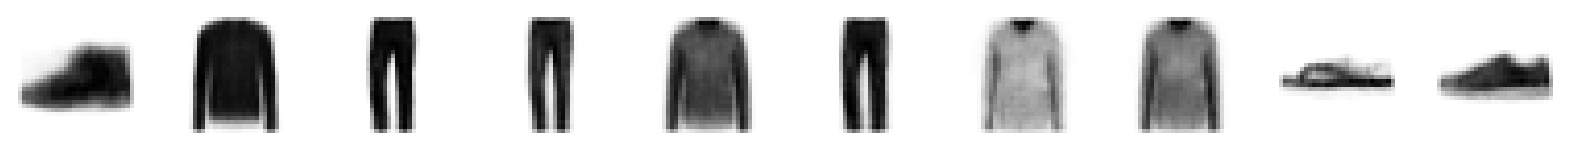

In [12]:
print("Reconstructions")
display(reconstructions.detach().numpy())

In [13]:
z_mean, z_var, z = encoder(example_images)
print(z[:10])

tensor([[ 1.1564, -0.9114],
        [-1.3892, -0.1063],
        [ 0.2139,  3.6970],
        [ 0.7591,  1.7124],
        [-0.2453,  0.0771],
        [ 0.2407,  1.9356],
        [ 0.1884,  0.4894],
        [ 0.0623,  0.2752],
        [ 2.8123,  0.7446],
        [ 2.7860,  0.2088]], grad_fn=<SliceBackward0>)


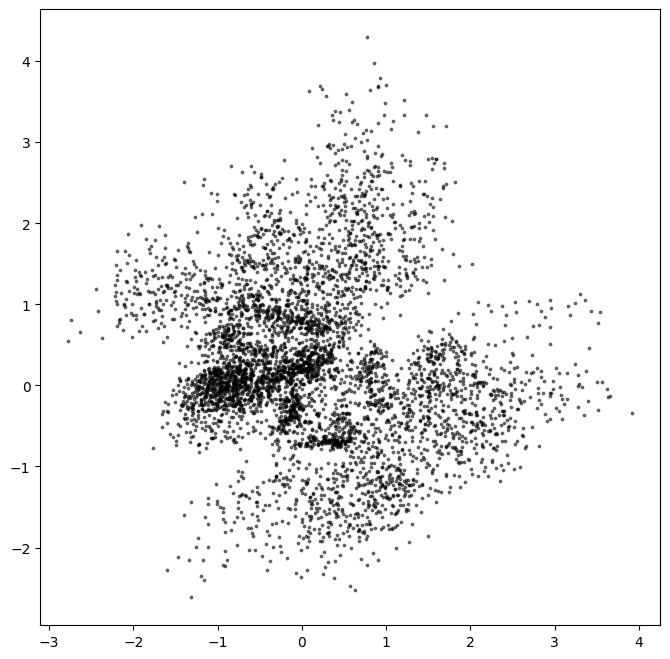

In [15]:
# Show the encoded points in 2D space
figsize = 8
z = z.detach().numpy()
plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)


In [17]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 2))

# Decode the sampled points
reconstructions = decoder(torch.Tensor(z_sample))

In [18]:
from scipy.stats import norm

p = norm.cdf(z)
p_sample = norm.cdf(z_sample)

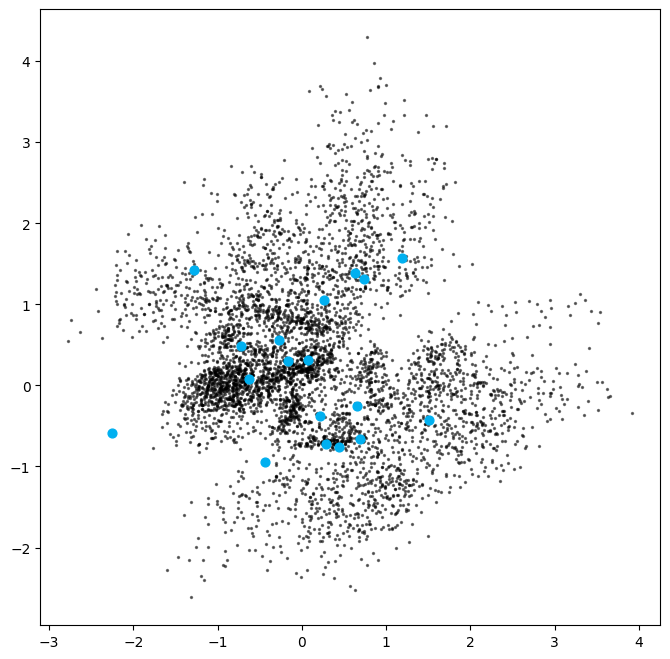

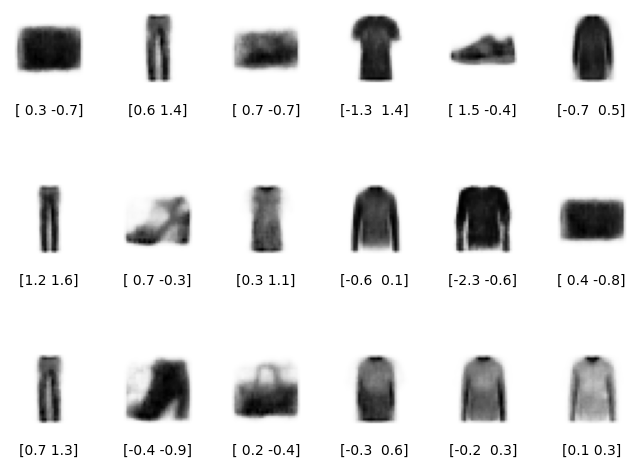

In [21]:
# Draw a plot of...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(z_sample[:, 0], z_sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(z_sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(np.transpose(reconstructions[i, :, :].detach().numpy(), (1, 2, 0)), cmap="Greys")

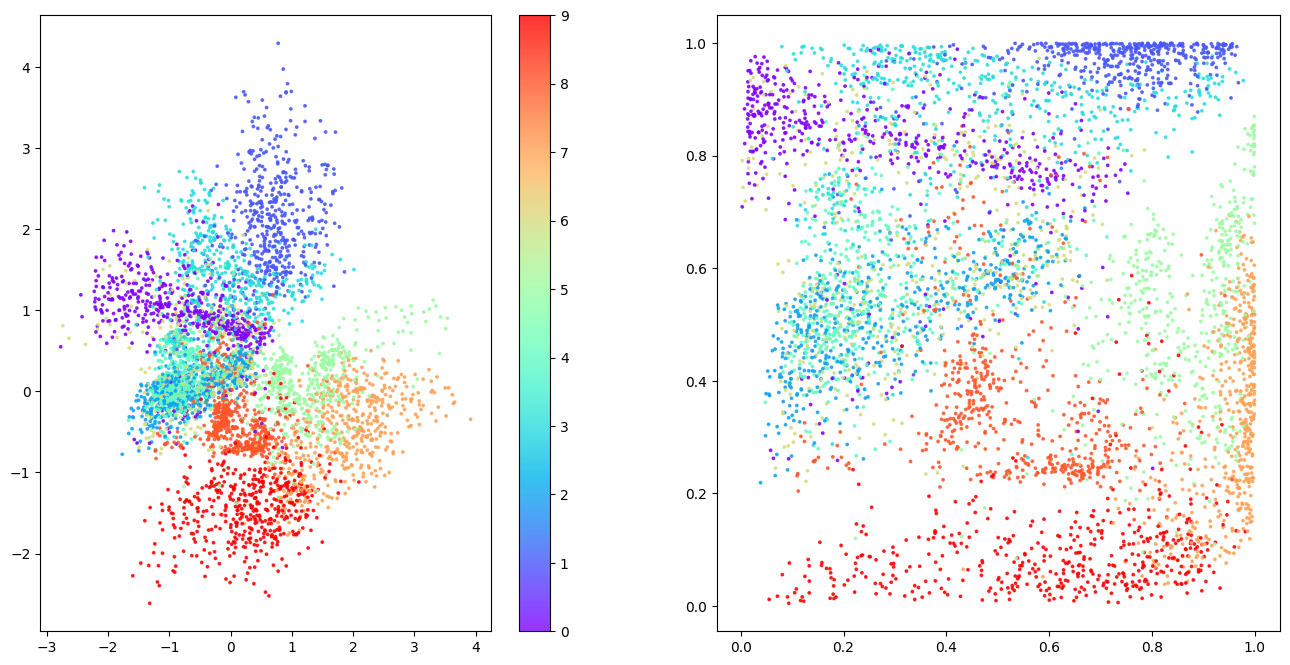

In [22]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 8
fig = plt.figure(figsize=(figsize * 2, figsize))
ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(
    z[:, 0], z[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.colorbar(plot_1)
ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.show()

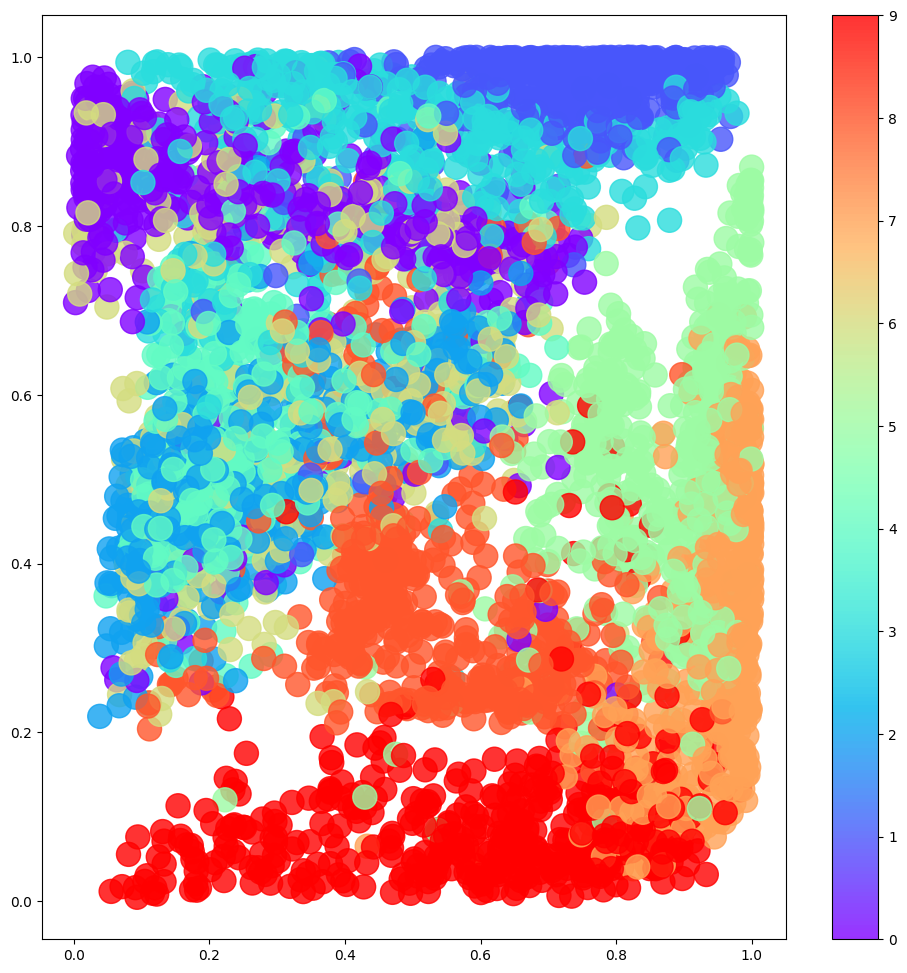

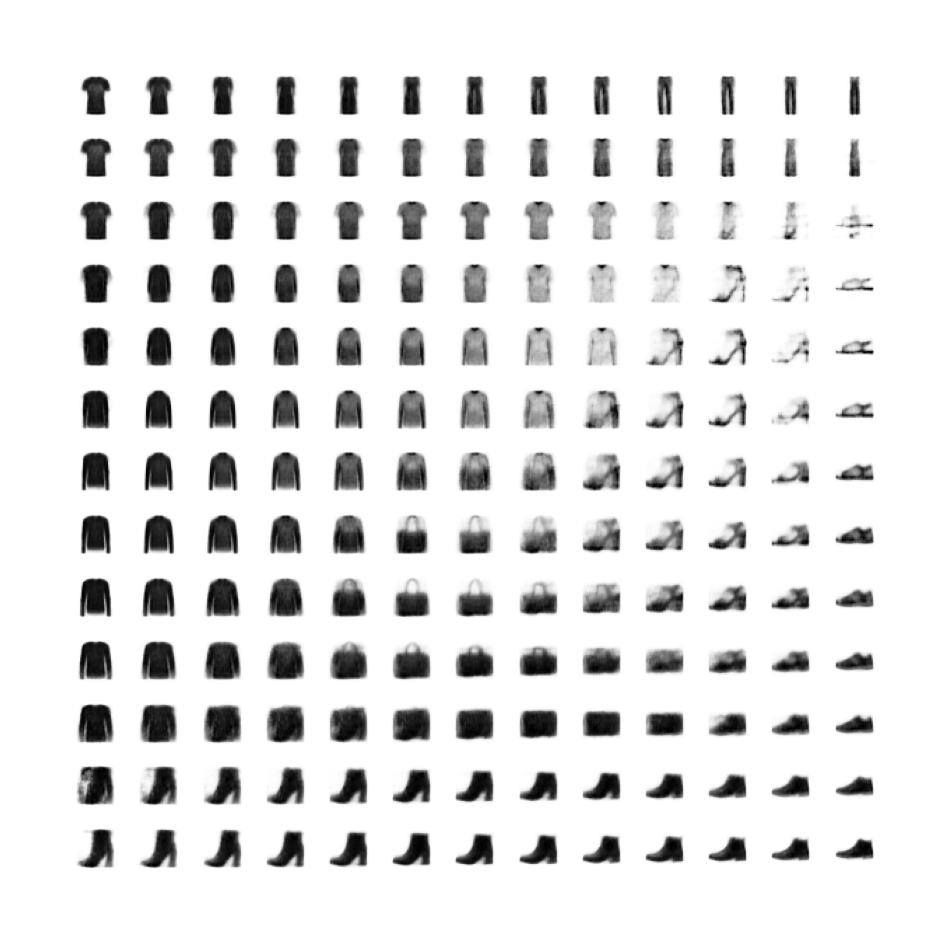

In [25]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=300
)
plt.colorbar()

x = norm.ppf(np.linspace(0, 1, grid_size))
y = norm.ppf(np.linspace(1, 0, grid_size))
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder(torch.Tensor(grid))
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(np.transpose(reconstructions[i, :, :].detach().numpy(), (1, 2, 0)), cmap="Greys")